# ノンパラメトリック法
## Agenda

- cross validation methodとは何か？いつ計量経済学で使われるのか学習する
- nonparametric methodをKDEを通して学習する
- `scipy`, `sklearn`の関連methodを軽く触れる


### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.15.4
BuildVersion:	19E287


### Python

In [3]:
!python -V

Python 3.7.4


### Install packages

In [4]:
#!brew install geos
#!brew install proj
#!pip install Cartopy
#!pip install geoplot

### Import

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm

import scipy.stats as st

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import cartopy.crs as ccrs

## 1. ノンパラメトリック法とNaive estimator

- ノンパラメトリック法とは何らかの関数を推定する際に、事前に関数形を特定せずに推定する方法を指す
- とある確率変数の密度関数を推定するときに、正規分布などの関数形を仮定してパラメータを求めてpdfを導出する方法をパラメトリック法という（パラメータは有限個）。一方、ノンパラでは密度関数の形に仮定はおかない

### Non-parametric methodのメリット

- 関数の定式化による誤りを回避することができる
- EDAの段階で活躍する

### Example: Nonparametr Density and Regression Estimation (DiNardo and Tobias 2001)
#### Question

- 1979年から1989年にかけての女性の賃金格差の拡大を分析したいとする


考えられる手法として log wageのstandard deviationをそれぞれ計算する
- 0.41 in 1979
- 0.50 in 1989

#### ParametricとNonparametric methodによるEDAの情報量の差

- Parametric methodはlog wageがnormal distributionに従う仮定の元推定(上段のfigure)
- Non-parametric methodだとlog wageのどの地点でspikeが発生しているのかが一目瞭然(下段のfigure)
- vertical dotted lineはそれぞれの年のreal termの最低賃金で、最低賃金水準が格差拡大の一つの要因であることが推測される

<img src = './materials/fig_1.jpg'>



### Histogram と KDEの差異

- どちらもpdfのestimator
- KDE: binのオーバーラップを許容する（ただし、$x_0$におけるpdfを評価するときdata pointが遠ければ遠いほど小さいweightが割り当てられる）
- Histogram: dataはnon-overlapping binsに分けられる

$$
pdf(x_0) = \frac{1}{N}\sum_{i = 1}^N I\left(x_i \in (x_0 - a , x_0 + a]\right) \tag{1}
$$

(1)からわかるようにbin-centerをどのように定めるかによってhistogramの形状は異なる。


### ナイーブ推定量としてのHistogram

$\{X_1, ..., X_n\}\sim F$とする。

このときの経験分布関数は

$$
F_n(x) = \frac{1}{n}\sum_{i = 1}1\{X_n \leq x\}
$$


In [6]:
sample = np.random.normal(loc=20, scale=5, size=300)
ecdf = ECDF(sample)
print('P(x<20): %.3f' % ecdf(20))

P(x<20): 0.527


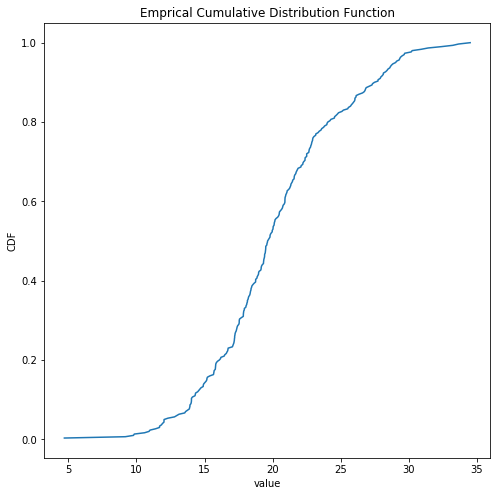

In [7]:
fig, ax = plt.subplots(1, figsize = (8, 8))
ax.plot(ecdf.x, ecdf.y)
ax.set_title('Emprical Cumulative Distribution Function')
ax.set_xlabel('value')
ax.set_ylabel('CDF');

このECDFには特定の仮定を置いていないのでノンパラメトリック推定量の一種である。

密度関数は分布関数の同関数であるので、ECDFを微分して密度関数を推定することが考えられる。ただし、ECDFは二連続関数なのでこの方法は上手くいかないが近似することはできる。

$$
f(x) = \lim_{h\to 0}\frac{F(x + h) - F(x-h)}{2h}
$$

十分小さな$h>0$に対して

$$
f(x)\approx \frac{F(x + h) - F(x-h)}{2h}
$$

従って、Fを$F_n$で書き換えることにより

$$
f_n(x) = \frac{F_n(x + h) - F_n(x-h)}{2h}\tag{2}
$$

この推定量をナイーブ推定量（Rosenblatt推定量）と呼ぶ。

- h: bandwidth, smoothing parameter

また、(2)を書き換えると

$$
f_n(x) = \frac{1}{2nh}\sum1 \{x-h\leq X_i\leq x+h\}
$$

xを固定した下でバンド幅を広げると

- 観測数が増えて分散が小さくなる
- 微分の近似が不正確になり推定量にバイアスが生じる
- この二つを分散とバイアスのトレードオフという

### Variance-Bias Trade-off in details

ここではNaive estimatorのVariance-Bias Trade-offの詳細を説明する。

- $\{X_1, ..., X_n\}\sim F$でsupportは$[0, 1]$とする。
- M: binの個数
- h: bandwidth, $h = 1/M$
- $f()$: True density function, smooth
- $|f'(x)|\geq L$ for all x (the derivative is bounded)

というsettingを用いて説明する。

まず、Partitionの設定をする

$$
B_1 = \left[0, \frac{1}{M} \right), B_2 = \left[\frac{1}{M}, \frac{2}{M} \right),  ..., B_M = \left[ \frac{M-1}{M}, 1 \right]
$$

このとき, $x \in B_l$のNaive estimatorは

$$
f_n(x) = \frac{M}{n}\sum 1\{X_i\in B_l \} = \frac{1}{nh}\sum 1\{X_i\in B_l\}
$$

- Intuitionとしては、同じBinの中の観測値に対して等しいweightを割与えてdensity functionを推定している

#### Bias Part

$x\in B_l$について、

$$
\begin{aligned}
E(\hat f_n(x)) & = M\cdot Pr(X_i\in B_l) \  \ \text{ by the above definition}\\
& = M\cdot \int^{l/M}_{(l-1)/M}f(u)du \  \  \text{ CDFの定義より}\\
& = M\cdot \left( F\left(\frac{l}{M}\right)- F\left(\frac{l-1}{M}\right)\right) \\
& = \left( F\left(\frac{l}{M}\right)- F\left(\frac{l-1}{M}\right)\right)/\frac{1}{M}\\
& = \left( F\left(\frac{l}{M}\right)- F\left(\frac{l-1}{M}\right)\right)\left(\frac{l}{M}-\frac{l-1}{M}\right)\\
& = f(x^*), \text{ where } \  \ x^* \in \left[\frac{l-1}{M}, \frac{l}{M}\right]\text{  by the mean value theorem}
\end{aligned}
$$

Mean-Value Theoremより
$$
\frac{f(x^*) - f(x)}{x^* - x} = f'(x^{**})
$$

よって、$x\in B_l$についてのNaive estimatorのbiasは

$$
\begin{aligned}
\text{bias}(\hat f_n(x)) & = \mathbf E(\hat f_n(x)) - f(x)\\
& = f(x^*) - f(x)\\
& = f'(x^**)\cdot (x^* - x) \  \ \text{by the mean value theorem}\\
& \leq |f'(x^**)|\cdot |(x^* - x)|\\
& \leq \frac{L}{M}
\end{aligned}
$$

#### REMARKS

- Mが大きいほどバイアスが小さい→ビンの数が多いほどバイアスが小さい
- Lが小さいほどバイアスが小さい


#### Variance Part

$x\in B_l$についてのNaive estimatorのvarianceは

$$
\begin{aligned}
Var(\hat f_n(x)) &= \frac{M^2}{n}Var\left(\sum^n_{i = 1}I(X_i\in B_l)\right)\\
&= M^2\cdot \frac{Pr(X_i\in B_l)(1 - Pr(X_i\in B_l))}{n}
\end{aligned}
$$

ここで、biasの式変形より$Pr(X_i\in B_l) = p(x^*)/M$なので

$$
\begin{aligned}
Var(\hat p_n(x)) = M\cdot\frac{p(x^*)}{n}+\frac{p^2(x^*)}{n}
\end{aligned}
$$

#### MSE Part

とある$x\in B_l$についてのMSEは

$$
\text{MSE}(\hat p_n(x)) = \text{bias}^2(\hat p_n(x)) + Var(\hat p_n(x)) = \left(\frac{L}{M}\right)^2 + M\cdot\frac{p(x^*)}{n}+\frac{p^2(x^*)}{n}
$$

よってMSEを最小化するような$M$は

$$
M_{opt} = \left(\frac{2n\cdot L^2}{p(x^*)}\right)^{1/3}
$$

#### MISE, Mean Integrated Squared Error

- MSEはある一点xにおける$f_n(x)$のパフォーマンスを評価する指標
- 関数全体としての推定量の良さはMISEを用いて判断すべき

$$
\text{MISE}[f_n] = \int\text{MSE}[f_n] dx = \int\mathbb E[f_n(x) - f(x)] dx 
$$




### Optimal bandwidthを調べ方

Naive estimatorをより一般化すると

$$
\hat{f}_h(x)=\frac{1}{nh}\sum_{i=1}^n \sum_j I(X_i\in B_j) I(x\in B_j)
$$

Optimal bandwidthはMISEを最小化するような`h`なのでISEをまず定義すると

$$
\begin{align*} 
ISE(h) & = \displaystyle \int \left(\hat{f}_h(x) – f(x)\right)^2\, dx \\ 
& = \displaystyle \int \hat{f}_h^2(x)\, dx – 2 \int \hat{f}_h(x) 
f(x)\, dx + \int f(x)^2\, dx 
\end{align*}
$$

最後の$\int f(x)^2\, dx $は最小化問題とは関係がないので

$$
h_{opt} = \arg\min \int \hat{f}_h^2(x)\, dx – 2 \int \hat{f}_h(x) f(x)\, dx 
$$

このとき$f(x)$はunknown function. もし$f_h(x)$がランダムではない確定的な関数ならば、

$$
\int \hat{f}_h(x) f(x)\, dx = \mathbb E[\hat{f}_h(x)]
$$

なので、標本平均で置き換えて推定することができる。

$$
\begin{equation*} 
\frac{1}{n} \sum_{i=1}^n \hat{f}_h(X_i). 
\end{equation*}
$$

として推定してしまうとover-fit問題を引き起こす and ランダムではない確定的な関数という仮定を満たさない使用することができない。ここでCross-validationを使う。今回はLeave-one-out methodで説明する。

LOOとは

$$
\begin{equation*} 
\frac{1}{n} \sum_{i=1}^n \hat{f}_{h, -i}(X_i). 
\end{equation*}
$$

実際に、

$$
\begin{aligned}
\mathbb E\left(\frac{1}{n}\sum^n_{i = 1}\hat f_{-i}(X_i)\right)& = \mathbb E\left(\hat f_{-i}(X_i)\right) \\
& = \mathbb E\left[\mathbb E\left(\hat f_{-n}(X_n)|X_1, ..., X_{n-1} \right)\right]\\
& = \mathbb E\left(\int \hat f_{-n}(x)f(x)dx\right)\\
& =\mathbb E\left(\int \hat f_{n}(x)f(x)dx\right)
\end{aligned}
$$

次に$\int \hat{f}_h^2(x) dx$を考える。

$$
\begin{equation*} 
N_k = \sum_{i=1}^n I(X_i\in B_k). 
\end{equation*}
$$

とすると、

$$
\begin{align*} 
\int \hat{f}_h^2(x)\, dx & = \displaystyle \frac{1}{n^2h^2} \int 
\left(\sum_k \sum_{i=1}^n I(x \in B_k) I(X_i \in B_k)\right)^2\, 
dx \\ 
& = \displaystyle \frac{1}{n^2h^2} \int \left(\sum_k I(x \in B_k) 
N_k \right)^2\, dx \\ 
& = \displaystyle \frac{1}{n^2h^2} \int \sum_k I(x \in B_k) N_k^2 + 
\sum_{k\neq l} I(x \in B_k) I(x \in B_l) N_k N_l \ dx. 
\end{align*}
$$


このとき、$\sum_{k\neq l} I(x \in B_k) I(x \in B_l) N_k N_l \ dx = 0$なので
$$
\begin{align} 
\int \hat{f}_h^2(x)\, dx 
& = \frac{1}{n^2h^2} \sum_k N_k^2 \int I(x \in B_k) \, dx \nonumber\\ 
& = \frac{1}{n^2h} \sum_k N_k^2. \tag{3}
\end{align}
$$

同様に

$$
\begin{align} 
\sum_{i=1}^n \hat{f}_{h, -i}(X_i) & = \displaystyle \frac{1}{(n-1)h} 
\sum_k \sum_{i=1}^n I(X_i\in B_k) \left(N_k – I(X_i\in B_k) 
\right) \nonumber \\ 
& = \displaystyle \frac{1}{(n-1)h} \sum_k N_k^2 – 
N_k. \tag{4}
\end{align}
$$

よって、(3), (4)より

$$
h_{opt} =\arg\min \frac{2}{(n-1)h} – \frac{n+1}{n^2(n-1)h} \sum_k N_k^2. \tag{5}
$$


### Optimal bandwidth search in Python

`matplotlib.pyplot.hist`のdefault設定は`rcParams["hist.bins"] (default: 10)`となっている。

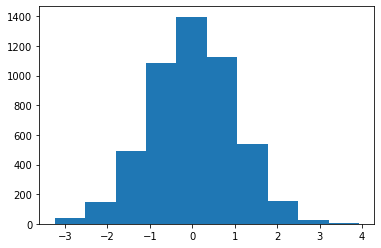

In [8]:
np.random.seed(42)
x = np.random.normal(0, 1, 5000) # mean 0 , var 1
plt.hist(x, bins = np.linspace(min(x), max(x), 11));

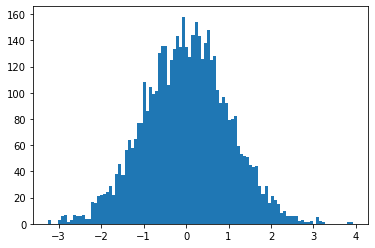

In [9]:
plt.hist(x, bins = np.linspace(min(x), max(x), 101));

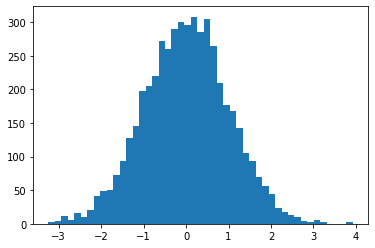

In [10]:
plt.hist(x, bins = 'auto');

In [11]:
def loo_bandwidth_seach(data, bins_upper_bound = 100):
    n = data.size
    if n <= 1:
        return 0
    
    _min = min(data)
    _max = max(data)
    
    def jhat(nbins):
        h_range = (_max - _min)/nbins
        first_term = 2/((n - 1)*h_range)
        second_term = ((n+1)/(n**2 * (n-1) * h_range))*sum(np.histogram(data, bins = nbins)[0]**2)
        return first_term - second_term
    
    nbins_upper_bound = max(bins_upper_bound, int(n**(1/2)))
    nbins = min(range(1, nbins_upper_bound + 1), key = jhat)
    return np.linspace(_min, _max, nbins + 1), nbins

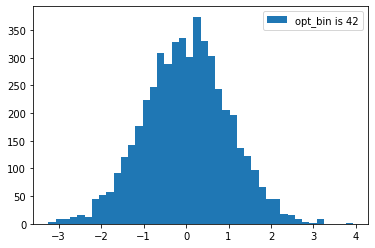

In [12]:
opt_bins, opt_bincount = loo_bandwidth_seach(x, bins_upper_bound = 100)
plt.hist(x, bins = opt_bins, label = 'opt_bin is %.0f' % opt_bincount)
plt.legend();

#### REMARKS: 

- numpyやmatplotlib.pyplotのbinsは`numpy.histogram_bin_edges`に基づいて計算される
- https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges

## 2. カーネル密度推定量

- カーネルとはsmoothing or weight-assiging functionのこと
- histogramはbin内部のsampleに同じweightをassignしている（rectangular kernel）
- 多くの場合、評価地点より遠いサンプルには小さいweight, 近いほど大きいweightを与えるカーネルが用いられる

### 短所

- 新しいデータ点での密度の計算が O(n) かかる
- 高次元データでは精度が悪い(次元の呪い)

### KDEの定義

$$
\hat f_n(x) = \frac{1}{nh}\sum_{i=1}^nK\left(\frac{X_i-x}{h}\right)
$$

- $k(\cdot)$はweight functionなので$\int k(x)dx = 1$を満たさなくてはならない
- $\kappa_1 = \int uk(u)du = 0$を満たさなくてはならない

<img src = './materials/table1.jpg'>


### Gaussian Kernelの例

$$
f_n(x_0) = \frac{1}{N\cdot \text{bandwidth}}\sum\frac{1}{\sqrt{2\pi}}\exp\left(-0.5\cdot \left(\frac{x_i - x_0}{\text{bandwidth}}\right)^2\right)
$$


In [13]:
def data_generating(N, f = 0.3, _seed = 42):
    """
    meanが異なるnormal distributionを二つ1D-arrayで生成する
    """
    rand = np.random.RandomState(_seed) ### instance化
    x = rand.randn(N) # a univariate “normal” (Gaussian) distribution of mean 0 and variance 1
    x[int(f*N):] += 5
    np.random.shuffle(x)
    return x

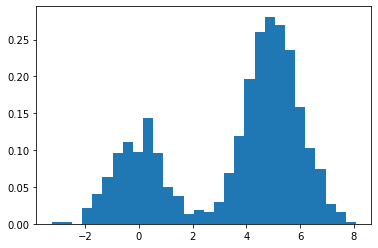

In [14]:
x = data_generating(1000)
hist = plt.hist(x, bins = 30, density = True);

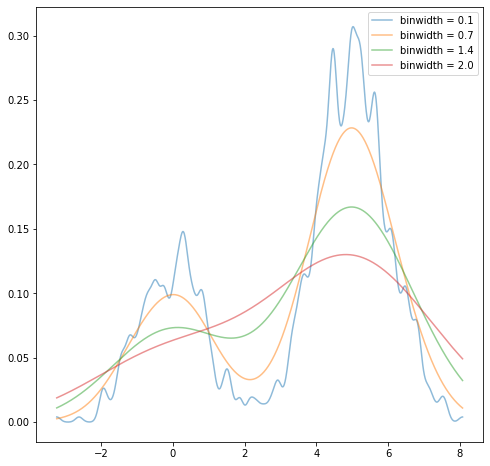

In [15]:
plt.figure(figsize = (8, 8))

x_d = np.linspace(min(x), max(x), 1000)

# instantiate and fit the KDE model
for width in np.linspace(0.1, 2, 4):
    kde = KernelDensity(bandwidth = width, kernel='gaussian')
    kde.fit(x[:, None])
    logprob = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(logprob), alpha=0.5, 
             label = 'binwidth = {}'.format(round(width, 1)))
    plt.legend()

### Bandwidth Selection

huristicにはsolverman methodが知られている

$$
h = 0.9\min \{\hat s, \frac{\hat q(0.75) - \hat q(0.25)}{1.34}\}N^{-1/5}
$$

- 0.9ではなく1.06の場合Scottのルールと呼ぶ
- 後述するCross validation Least Squareによるbandwidth selectionと比べパフォーマンスに遜色はない

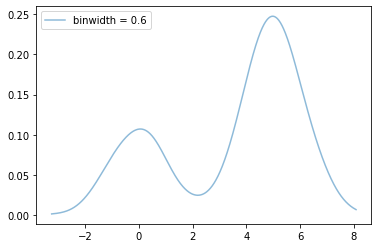

In [16]:
h = 0.9*min(np.std(x), 
            (np.quantile(x, 0.75) - np.quantile(x, 0.25))/1.34)/len(x)**(0.2)
kde = KernelDensity(bandwidth = h, kernel='gaussian')
kde.fit(x[:, None])
logprob = kde.score_samples(x_d[:, None])
plt.plot(x_d, np.exp(logprob), alpha=0.5, 
             label = 'binwidth = {}'.format(round(h, 1)))
plt.legend();

### カーネル密度推定量の評価

Histogramの場合と同様にMSEで評価する。

$$
\begin{aligned}
\text{MSE}[\hat f(x)]&= \mathbb E[(\hat f(x) - f(x))^2]\\
& = \text{Bias}^2[\hat f(x)] + \text{Var}[\hat f(x)]\\
& (\mathbb E[\hat f(x)] - f(x))^2 + \mathbb E[(\hat f(x) - f(x))^2]
\end{aligned}
$$

#### Bias Part

無作為標本の仮定より

$$
\begin{aligned}
\mathbb E[\hat f(x)] & = \frac{1}{h}\mathbb E\left[k\left(\frac{X_i - x}{h}\right)\right]\\
& = \frac{1}{h}\int k\left(\frac{z - x}{h}\right)f(z)dz\\
& = \int k(u)f(x + hu)du
\end{aligned}
$$

- $u = (z- x)/h$の変数変換を行った

x周りでテイラー展開すると、$\kappa_1 = 0$と$h\to 0$の仮定より

$$
\begin{aligned}
\int k(u)f(x + hu)du &\approx \int k(u)\left\{f(x) + f'(x)hu + \frac{f''(x)}{2}h^2u^2\right\}du\\
& = f(x) + \frac{h^2}{2}\kappa_2
\end{aligned}
$$

where

$$
\kappa_2 = \int k(u)u^2du
$$

よってバイアスは近似的に

$$
\text{Bias}[\hat f(x)] = \frac{h^2}{2}\kappa_2\tag{6}
$$


#### Variance Part

$$
\begin{align*}
\text{Var}[\hat f(x)] &= \text{Var}\left(\frac{1}{nh}\sum k\left(\frac{X_i- x}{h}\right)\right)\\
&= \frac{1}{nh^2}\text{Var}\left(k\left(\frac{X_i- x}{h}\right)\right)\\
&= \frac{1}{nh^2}\mathbb E\left[k^2\left(\frac{X_i- x}{h}\right)\right] - \frac{1}{n}\left(\frac{1}{h}\mathbb E\left[k\left(\frac{X_i- x}{h}\right)\right]\right)^2\tag{7}
\end{align*}
$$

(6)のthe second termは

$$
\frac{1}{h}\mathbb E\left[k\left(\frac{X_i- x}{h}\right)\right] = f(x) + O(h^2)
$$

より

$$
\frac{1}{n}\left(\frac{1}{h}\mathbb E\left[k\left(\frac{X_i- x}{h}\right)\right]\right)^2 = O(n^{-1})\tag{8}
$$

the first termについてはテイラー展開を用いると、

$$
\begin{align*}
\frac{1}{nh^2}\mathbb E\left[k^2\left(\frac{X_i- x}{h}\right)\right] &= \frac{1}{nh}\int k^2(u)f(x+hu)du\\
&\approx \frac{1}{nh}\int k^2(u)\{f(x) + f'(x)hu\}du\\
& = \frac{f(x)R(k)}{nh} + O\left(\frac{1}{n}\right)
\end{align*}
$$

where $R(k) = \int k^2(u)du$.

$n\to\infty$, $h\to 0$のとき$n^{-1}$の方が$(nh)^{-1}$よりも早く0に収束する。よって、分散は近似的に

$$
\text{Var}[\hat f(x)] = \frac{f(x)R(k)}{nh}\tag{9}
$$

#### Intuition

- hが小さいほどバイアスは小さいが、分散が大きくなってしまう
- MSEが0に収束するためには$nh\to \infty$の条件も必要



#### MSEのオーダー

(6), (9)より
$$
\text{MSE}[\hat f(x)] = \text{Bias}^2[\hat f(x)] + \text{Var}[\hat f(x)] = O(h^4) + O\left(\frac{1}{nh}\righ)
$$

なお、２次カーネルを用いた場合、MISEの近似は

$$
\text{MISE}[\hat f] = \frac{h^4}{4}\kappa_2^2R(f'') + \frac{R(k)}{nh}
$$

なおこのFOCを求めると、最適なバンド幅が導出される

$$
h_{opt} = \left(\frac{R(k)}{\kappa_2^2 E(f'')}\right)^{1/5}n^{-1/5}
$$

### Bandwidth Selection and Cross-Validation

Histogramにおけるbadnwidth Selectionと同様に

$$
h_{opt} = \arg\min \mathbb E\left[\int (\hat f_h(x) - f(x))^2dx\right]
$$

Then,

$$
h_{opt}= \arg\min \int \hat f_h(x)^2 dx - \frac{2}{n}\sum_i \hat f_{h, -i}(X_i)
$$


#### Python with sklearn

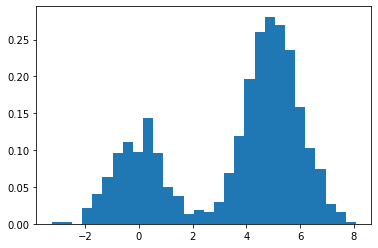

In [17]:
x = data_generating(1000)
hist = plt.hist(x, bins = 30, density = True);

In [18]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
loo = LeaveOneOut()
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv = loo)
grid.fit(x[:, None]);

In [19]:
grid.best_params_

{'bandwidth': 0.35111917342151316}

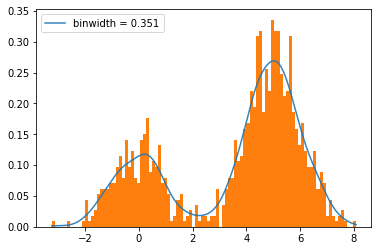

In [20]:
width = grid.best_params_.values()
kde = KernelDensity(bandwidth = list(width)[0], kernel='gaussian')
kde.fit(x[:, None])
logprob = kde.score_samples(x_d[:, None])
plt.plot(x_d, np.exp(logprob), alpha=0.9, label = 'binwidth = {}'.format(round(list(width)[0], 3)))
plt.legend()
plt.hist(x, bins = 100, density = True);

#### KDE with statsmodels

- [公式ドキュメント](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html)

In [21]:
dens_u = sm.nonparametric.KDEMultivariate(data=x,var_type='c', bw='cv_ls')

In [22]:
print('The bandwidth is %.3f' % dens_u.bw)

The bandwidth is 0.320


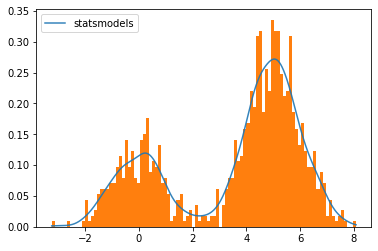

In [23]:
plt.plot(x_d, dens_u.pdf(x_d), alpha=0.9, label = 'statsmodels')
plt.legend()
plt.hist(x, bins = 100, density = True);

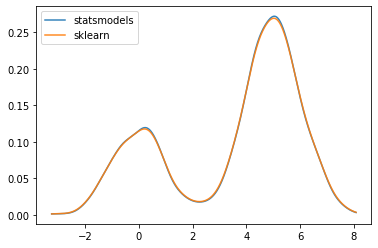

In [24]:
plt.plot(x_d, dens_u.pdf(x_d), alpha=0.9, label = 'statsmodels')
plt.plot(x_d, np.exp(logprob), alpha=0.9, label = 'sklearn')
plt.legend();

### 多変量密度関数と次元の呪い

カーネル密度推定は多変量へ拡張できる。$\{\mathbf X_1, ..., \mathbf X_n\}$を無作為標本とし、$\mathbf X_i = (X_{1i}, ..., X_{qi})'$とする。

$\mathbf X_i$の密度関数は

$$
\hat f(\mathbf x) = \frac{1}{nh_1\cdots h_q}\sum_{i = 1}^n K\left(\frac{\mathbf X_i - \mathbf x}{\mathbf h}\right) = \frac{1}{n}\sum_{i=1}^n\prod^q_{j = 1}\frac{1}{h_j}k\left(\frac{\mathbf X_{ij} - x_j}{h_j}\right)
$$

#### MISE

$$
\text{MISE}[\hat f] = \frac{\kappa_2^2}{4}\int_{\mathbb R^q}\left(\sum_{s=1}^q \frac{\partial^2 f(\mathbf x)}{\partial x_s^2}h_s^2\right)dx + \frac{R^q(k)}{nh_1\cdots h_q}
$$

ここで、$h_1 = h_2 = ... = h_q$とすると$h_{opt} = O(n^{-1/(q+4)})$で、MISEが0に収束するスピードはqが大きくなるにつれて遅くなる。このことを次元の呪いという。


## 3. Kernel Density Estimation and Python

ここでは台風のlocationの分布をKDEを用いて推定する。

In [25]:
### Read Data
url = 'https://raw.githubusercontent.com/ipython-books/cookbook-2nd-data/master/Allstorms.ibtracs_wmo.v03r05.csv'
df = pd.read_csv(url)
df.head()

,Serial_Num,Season,Num,Basin,Sub_basin,Name,ISO_time,Nature,Latitude,Longitude,Wind(WMO),Pres(WMO),Center,Wind(WMO) Percentile,Pres(WMO) Percentile,Track_type
0,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-11 06:00:00,NR,-8.6,79.8,0.0,0.0,reunion,-100.0,-100.0,main
1,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-12 06:00:00,NR,-9.0,78.9,0.0,0.0,reunion,-100.0,-100.0,main
2,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-13 06:00:00,NR,-10.4,73.2,0.0,0.0,reunion,-100.0,-100.0,main
3,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-14 06:00:00,NR,-12.8,69.9,0.0,0.0,reunion,-100.0,-100.0,main
4,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-15 06:00:00,NR,-13.9,68.9,0.0,0.0,reunion,-100.0,-100.0,main


In [26]:
### 出現回数の確認
df['Serial_Num'].value_counts()

1973325S09091    137
1899215N12329    133
2011045S14132    124
1994222N11267    121
1971249N26289    118
                ... 
1862279N13299      1
1851192N12300      1
1855219N22262      1
1861281N35285      1
1858218N45320      1
Name: Serial_Num, Length: 6940, dtype: int64

In [27]:
### 台風の出現場所の Latitude, Longitudeを抽出
pos = df.groupby(['Serial_Num'])[['Latitude', 'Longitude']].min()
pos.head()

,Latitude,Longitude
Serial_Num,,
1848011S09080,-27.2,67.0
1848011S15057,-34.1,46.7
1848061S12075,-34.5,56.5
1851080S15063,-19.4,48.1
1851080S21060,-26.8,59.5


In [28]:
### Convert a DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(pos, geometry=gpd.points_from_xy(pos.Longitude, pos.Latitude))
gdf.head()

,Latitude,Longitude,geometry
Serial_Num,,,
1848011S09080,-27.2,67.0,POINT (67.00000 -27.20000)
1848011S15057,-34.1,46.7,POINT (46.70000 -34.10000)
1848061S12075,-34.5,56.5,POINT (56.50000 -34.50000)
1851080S15063,-19.4,48.1,POINT (48.10000 -19.40000)
1851080S21060,-26.8,59.5,POINT (59.50000 -26.80000)


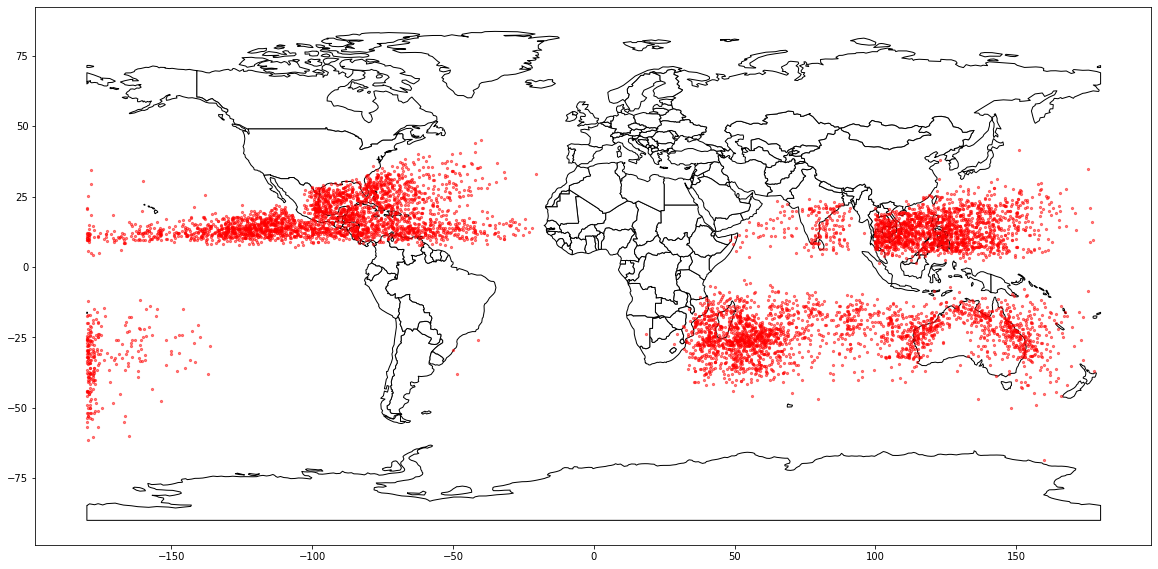

In [29]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize = (20, 10))
gdf.plot(ax=base, marker='o', color='red', markersize=5, alpha = 0.5);

#### PlateCarreeを用いたplot

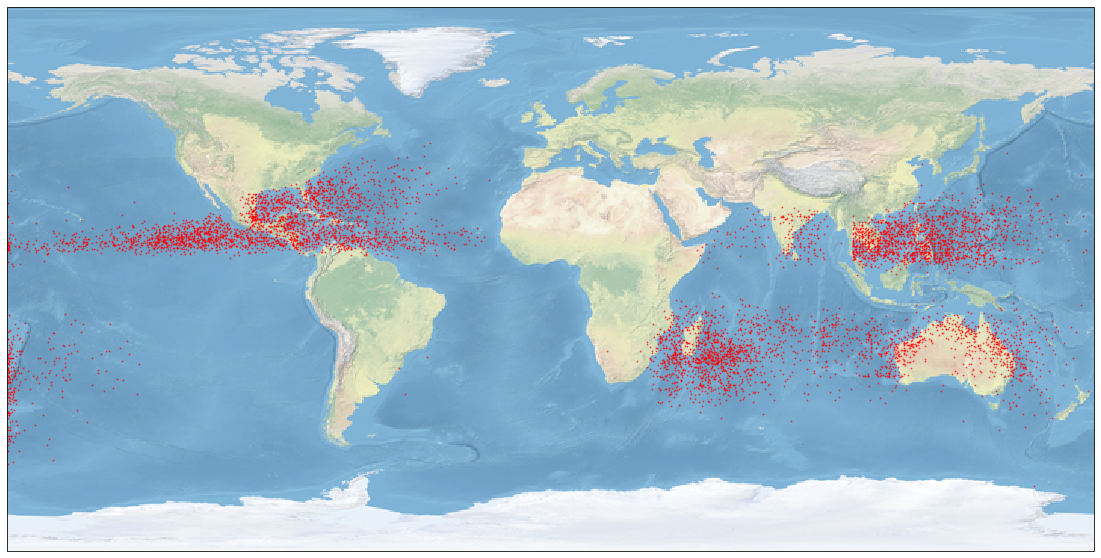

In [30]:
plt.figure(figsize=(20, 10))
crs = ccrs.PlateCarree()
ax = plt.axes(projection = crs)
ax.stock_img()
ax.scatter(pos.Longitude, pos.Latitude, color = 'r', s =1, alpha =0.5);

### KDE with ccrs

In [31]:
geo = ccrs.Geodetic()
learning_df = geo.transform_points(crs, pos.Longitude.values, pos.Latitude.values)[:, :2].T

In [32]:
kde_ccrs = st.gaussian_kde(learning_df)
k = 100
x0, x1, y0, y1 = ax.get_extent()
tx, ty = np.meshgrid(np.linspace(x0, x1, 2 * k), np.linspace(y0, y1, k))
mesh = np.vstack((tx.ravel(), ty.ravel()))
v = kde_ccrs(mesh).reshape((k, 2*k))

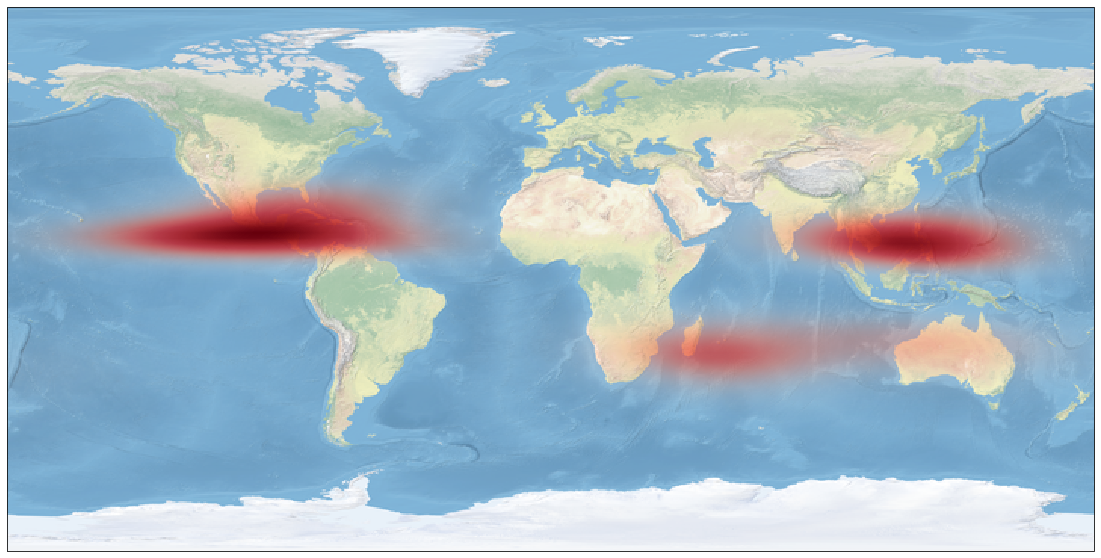

In [33]:
plt.figure(figsize=(20, 10))
cmap = plt.get_cmap('Reds')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)
ax = plt.axes(projection = crs)
ax.stock_img()
ax.imshow(v, origin = 'lower', extent = [x0, x1, y0, y1], interpolation = 'bilinear', cmap = my_cmap)

#### KDE with GeoPandas

In [34]:
### KDE learning phase
h = gdf.loc[:, ['Longitude', 'Latitude']].values
h = h.T
kde = sm.nonparametric.KDEMultivariate(data=h,var_type='cc', bw='normal_reference')

In [35]:
### Make a meshgrid
k = 100

lat_min, lon_min = -90, -180
lat_max, lon_max = 90, 180
tx, ty = np.meshgrid(np.linspace(lon_min, lon_max, 2 * k), np.linspace(lat_min, lat_max, k))
mesh = np.vstack((tx.ravel(), ty.ravel()))

In [36]:
### estimation
pred = kde.pdf(mesh).reshape(k, -1)

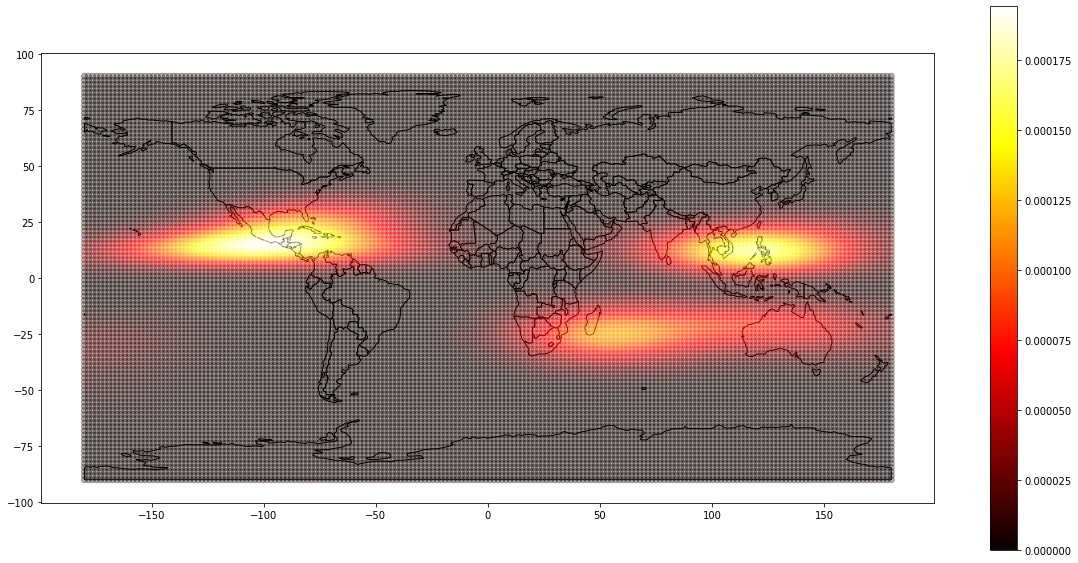

In [37]:
### plot
pred_df = pd.DataFrame({'Longitude': mesh[0], 
              'Latitude': mesh[1],
              'kde':pred.ravel()})
pred_df = gpd.GeoDataFrame(pred_df, geometry = gpd.points_from_xy(pred_df.Longitude, pred_df.Latitude))
base = world.plot(color='white', edgecolor='black', figsize = (20, 10))
pred_df.plot(column='kde', ax=base, cmap='hot', alpha = 0.3, legend=True);